In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

Step 1: Combine Forecasted Data

First, merge the forecasted prices for TSLA, BND, and SPY into a single DataFrame.

In [2]:
# Load forecasted data for each asset
tsla_forecast = pd.read_csv("tsla_forecast.csv", index_col=0, parse_dates=True)
bnd_forecast = pd.read_csv("bnd_forecast.csv", index_col=0, parse_dates=True)
spy_forecast = pd.read_csv("spy_forecast.csv", index_col=0, parse_dates=True)

# Combine forecasted data into a single DataFrame
df = pd.DataFrame({
    'TSLA': tsla_forecast['Forecast'],
    'BND': bnd_forecast['Forecast'],
    'SPY': spy_forecast['Forecast']
})

# Preview the combined data
print(df.head())

                 TSLA        BND        SPY
2025-01-31  399.90567  71.845270  604.42706
2025-02-01  398.99790  71.763230  604.85280
2025-02-02  396.88046  71.666916  604.79285
2025-02-03  395.39950  71.568820  604.59930
2025-02-04  394.69318  71.472310  604.37256


Step 2: Compute Annual Returns and Covariance Matrix

Calculate annualized returns, covariance, and daily returns for portfolio optimization.

In [3]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Compute average daily return and annualized return
average_daily_return = daily_returns.mean()
annual_return = (1 + average_daily_return) ** 252 - 1  # Assuming 252 trading days/year

# Compute the covariance matrix of daily returns
cov_matrix = daily_returns.cov()

# Display results
print("Annual Returns:")
print(annual_return)
print("\nCovariance Matrix:")
print(cov_matrix)

Annual Returns:
TSLA   -0.086599
BND    -0.172902
SPY     0.000467
dtype: float64

Covariance Matrix:
              TSLA           BND           SPY
TSLA  3.390846e-07  1.097551e-07  1.294776e-08
BND   1.097551e-07  7.950019e-08  7.665636e-09
SPY   1.294776e-08  7.665636e-09  8.295264e-09


Step 3: Portfolio Weighted Return and Risk

Define initial portfolio weights and compute weighted return and volatility.

In [4]:
# Initial weights (e.g., equal allocation)
weights = np.array([0.33, 0.33, 0.34])  # TSLA, BND, SPY

# Portfolio return
portfolio_return = np.dot(weights, annual_return)

# Portfolio volatility (risk)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # Annualized volatility

print(f"Portfolio Return: {portfolio_return}")
print(f"Portfolio Volatility: {portfolio_volatility}")

Portfolio Return: -0.08547663326136902
Portfolio Volatility: 0.00434953152971157


Step 4: Sharpe Ratio Optimization

Optimize portfolio weights to maximize the Sharpe Ratio.

In [5]:
from scipy.optimize import minimize

# Define risk-free rate (e.g., 3%)
risk_free_rate = 0.03

# Define the Sharpe Ratio function (negative for minimization)
def sharpe_ratio(weights):
    port_return = np.dot(weights, annual_return)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return -(port_return - risk_free_rate) / port_volatility  # Negative for maximization

# Constraints: Weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds: Weights must be between 0 and 1
bounds = tuple((0, 1) for _ in range(len(weights)))

# Perform optimization
optimized_result = minimize(sharpe_ratio, weights, bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = optimized_result.x

print("Optimized Weights:")
print(optimized_weights)

Optimized Weights:
[1.00000000e+00 3.17607052e-12 2.96929148e-13]


Step 5: Analyze Portfolio Risk and Return

Evaluate the optimized portfolio for risk, return, and Sharpe Ratio.

In [6]:
# Compute optimized portfolio metrics
optimized_portfolio_return = np.dot(optimized_weights, annual_return)
optimized_portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix * 252, optimized_weights)))
optimized_sharpe_ratio = (optimized_portfolio_return - risk_free_rate) / optimized_portfolio_volatility

print(f"Optimized Portfolio Return: {optimized_portfolio_return}")
print(f"Optimized Portfolio Volatility: {optimized_portfolio_volatility}")
print(f"Optimized Sharpe Ratio: {optimized_sharpe_ratio}")

Optimized Portfolio Return: -0.08659924306701816
Optimized Portfolio Volatility: 0.009243879706965316
Optimized Sharpe Ratio: -12.61366945084324


Step 6: Value at Risk (VaR)

Calculate VaR to measure Tesla's potential loss at a given confidence interval.

In [9]:
from scipy.stats import norm

# Confidence level (e.g., 95%)
confidence_level = 0.95

# Initialize a dictionary to store VaR for each market
var_results = {}

# Loop through each market to calculate VaR
for ticker in ['TSLA', 'BND', 'SPY']:
    # Calculate the daily standard deviation for the ticker
    std_dev = daily_returns[ticker].std()
    
    # Calculate VaR for the ticker
    var = norm.ppf(1 - confidence_level) * std_dev * df[ticker].iloc[-1]
    var_results[ticker] = var

    print(f"Value at Risk (VaR) for {ticker}: {var}")

# Example: Accessing the VaR results
print("\nSummary of VaR Results:")
for ticker, var in var_results.items():
    print(f"{ticker}: {var}")

Value at Risk (VaR) for TSLA: -0.3591557094279087
Value at Risk (VaR) for BND: -0.0291169294284568
Value at Risk (VaR) for SPY: -0.09057953685819843

Summary of VaR Results:
TSLA: -0.3591557094279087
BND: -0.0291169294284568
SPY: -0.09057953685819843


Step 7: Visualize Portfolio Performance

Plot cumulative returns for the optimized portfolio and individual assets.

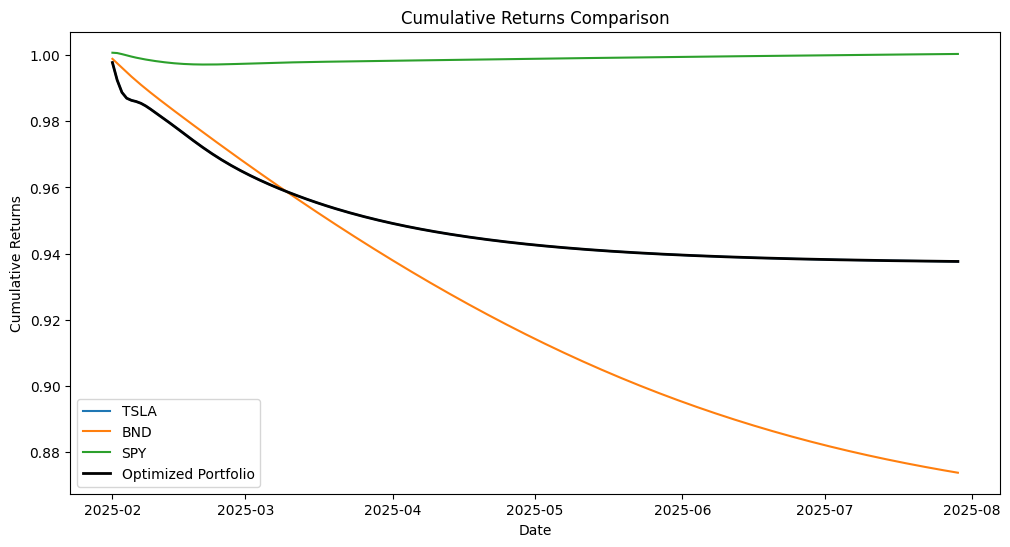

In [8]:
# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod()
portfolio_cumulative_returns = (1 + daily_returns.dot(optimized_weights)).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label=['TSLA', 'BND', 'SPY'])
plt.plot(portfolio_cumulative_returns, label='Optimized Portfolio', color='black', linewidth=2)
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()